In [147]:
import csv
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [148]:
#read data
testData = "data/test.csv"
trainData = "data/train.csv"

train = pd.read_csv(trainData)
test = pd.read_csv(testData)

In [149]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [150]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [151]:
#Missing data
print("Train dataset:\n",train.isnull().sum())

Train dataset:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [152]:
print("Test dataset:\n",test.isnull().sum())

Test dataset:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [153]:
#features in train dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [154]:
#Mean value for features Age and Fare, the most frequent value for Embarked  and a new category for Cabin

for df in [train, test]:
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)

for df in [train, test]:
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
for df in [train, test]:
    df['Cabin'] = df['Cabin'].fillna('Unknown')

In [155]:
#convert categorical
cabinEncoder = LabelEncoder()
cabinEncoder.fit(train['Cabin'])
train['Cabin'] = cabinEncoder.transform(train['Cabin'])

test['Cabin'] = test['Cabin'].apply(lambda x: cabinEncoder.transform([x])[0] 
                                     if x in cabinEncoder.classes_ 
                                     else cabinEncoder.transform(['Unknown'])[0])

#Sex and Embarked
train = pd.get_dummies(train, columns=['Sex', 'Embarked'])
test = pd.get_dummies(test, columns=['Sex', 'Embarked'])

In [156]:
train.drop(['Name', 'PassengerId', 'Survived', 'Ticket' ], axis=1, inplace=True)
test.drop(['Name', 'PassengerId',  'Ticket'], axis=1, inplace=True)

In [157]:
def clusterData(data, clusterCount, algorithm):
    # Initialize clustering model
    if algorithm == 'KMeans':
        clusterModel = KMeans(n_clusters=clusterCount, random_state=123)
    elif algorithm == 'Agglomerative':
        clusterModel = AgglomerativeClustering(n_clusters=clusterCount)
    else:
        raise ValueError('Invalid algorithm')

    # Perform clustering
    clusterModel.fit(data)
    labels = clusterModel.labels_

    # Calculate Silhouette Score
    score = silhouette_score(data, labels, metric='euclidean')
    print(f"Silhouette Score for {algorithm} algorithm; cluster count: {n_clusters}: {score:.2f}\n")

    # Calculate the mean value of each variable within each cluster
    clusterMeans = data.groupby(labels).mean()
    print("Profiling clusters...\n", clusterMeans)

    return labels

#Compared to its nearest neighbor cluster, a data point's silhouette score indicates how similar it is to its own cluster. 
#The silhouette is between -1 and +1.
#A value around 1 indicates that the sample's distance from its nearest neighbor cluster is much greater than the distance within the cluster. The ideal value is 1.
#Clusters that overlap are denoted by # 0.
#The lowest result is -1, and a result that is near to -1 indicates that the sample was placed in the incorrect cluster.


C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.71

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.565101  28.417863  0.530201  0.370470   17.994708  144.625503   
1  1.000000  36.237027  0.486301  0.438356  104.711587   59.910959   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.322148  0.677852    0.132886    0.100671    0.766443  
1    0.506849  0.493151    0.472603    0.013699    0.513699  


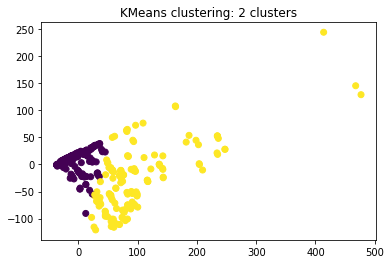

C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.71

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.577808  28.317061  0.527740  0.370771   18.007633  145.255751   
1  1.000000  31.019912  0.750000  1.050000  279.308545   63.800000   
2  1.000000  37.236422  0.462121  0.340909   74.243467   59.643939   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.324763  0.675237    0.136671    0.101488    0.761840  
1    0.600000  0.400000    0.600000    0.000000    0.400000  
2    0.469697  0.530303    0.416667    0.015152    0.568182  


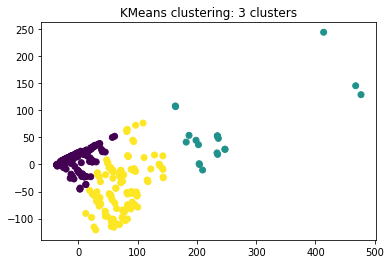

C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.71

Profiling clusters...
     Pclass        Age     SibSp     Parch        Fare       Cabin  Sex_female  \
0  2.58209  28.262290  0.529172  0.371777   17.986136  145.394844    0.322931   
1  1.00000  31.934756  0.685714  0.914286  190.907020   79.000000    0.714286   
2  1.00000  35.333333  0.000000  0.333333  512.329200   65.333333    0.333333   
3  1.00000  38.007667  0.448276  0.284483   62.236497   54.965517    0.431034   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0  0.677069    0.137042    0.101764    0.761194  
1  0.285714    0.428571    0.000000    0.571429  
2  0.666667    1.000000    0.000000    0.000000  
3  0.568966    0.422414    0.017241    0.560345  


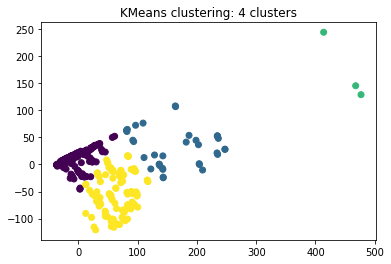

C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.65

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.384615  35.174560  1.219780  0.439560   79.736766  120.296703   
1  2.632035  28.012295  0.451659  0.356421   14.792093  145.558442   
2  1.000000  37.785600  0.298701  0.285714   53.145888   36.207792   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.000000  30.852495  0.703704  1.111111  205.843052   62.592593   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.505495  0.494505    0.384615    0.021978    0.593407  
1    0.317460  0.682540    0.129870    0.108225    0.761905  
2    0.363636  0.636364    0.363636    0.000000    0.636364  
3    0.333333  0.666667    1.000000    0.000000    0.000000  
4    0.703704  0.296296    0.444444    0.000000    0.555556  


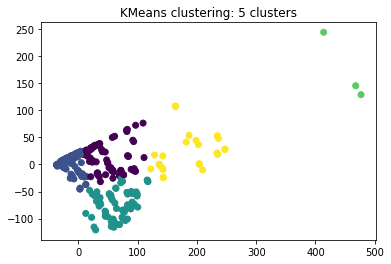

C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.60

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.653846  27.892192  0.421598  0.340237   14.160237  145.928994   
1  1.000000  30.258720  0.882353  1.176471  238.187253   63.529412   
2  1.000000  38.485791  0.267606  0.183099   48.534039   34.619718   
3  1.000000  33.927253  0.707317  0.658537  121.481398   84.097561   
4  1.578313  34.492590  1.421687  0.590361   61.551857  128.469880   
5  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.318047  0.681953    0.133136    0.110947    0.755917  
1    0.647059  0.352941    0.529412    0.000000    0.470588  
2    0.338028  0.661972    0.366197    0.000000    0.633803  
3    0.634146  0.365854    0.463415    0.048780    0.487805  
4    0.445783  0.554217    0.253012    0.000000    0.746988  
5    0.333333  0.666667    1.000000    0.000000    

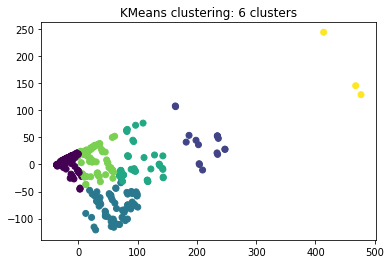

C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.43

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.574257  10.315320  1.673267  1.158416   26.966874  146.099010   
1  1.000000  38.485791  0.267606  0.183099   48.534039   34.619718   
2  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
3  1.000000  30.258720  0.882353  1.176471  238.187253   63.529412   
4  1.493506  36.132284  1.207792  0.506494   62.752001  127.025974   
5  2.667814  30.798578  0.242685  0.211704   12.264313  145.910499   
6  1.000000  33.927253  0.707317  0.658537  121.481398   84.097561   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.504950  0.495050    0.188119    0.039604    0.772277  
1    0.338028  0.661972    0.366197    0.000000    0.633803  
2    0.333333  0.666667    1.000000    0.000000    0.000000  
3    0.647059  0.352941    0.529412    0.000000    0.470588  
4    0.467532  0.532468    0.272727    0.00

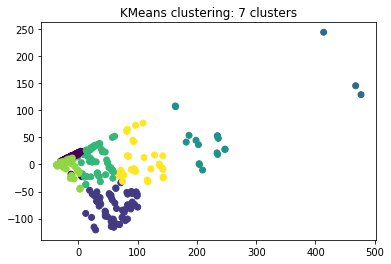

C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.40

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  36.235634  0.705882  0.568627  112.816747   86.156863   
1  2.274648  44.795775  0.267606  0.464789   18.256866  144.330986   
2  1.000000  30.258720  0.882353  1.176471  238.187253   63.529412   
3  1.000000  38.778184  0.260870  0.260870   54.871833   21.673913   
4  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
5  1.925373  27.599789  1.970149  0.820896   60.658766  141.731343   
6  2.755725  23.899662  0.421756  0.286260   12.714590  146.591603   
7  1.073171  36.002267  0.292683  0.170732   36.852746   73.682927   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.627451  0.372549    0.490196    0.039216    0.470588  
1    0.274648  0.725352    0.056338    0.042254    0.901408  
2    0.647059  0.352941    0.529412    0.000000    0.470588  
3    0.413043  0.586957    0.456522

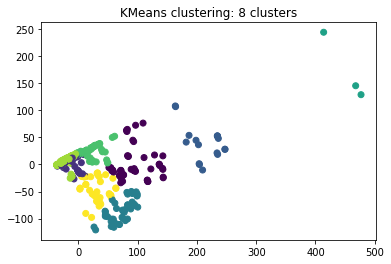

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.71

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  35.384482  0.434426  0.491803  108.633265   53.459016   
1  2.516255  28.797148  0.537061  0.364109   20.078922  143.005202   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0     0.47541   0.52459    0.450820     0.00000    0.549180  
1     0.33290   0.66710    0.146944     0.10013    0.752926  


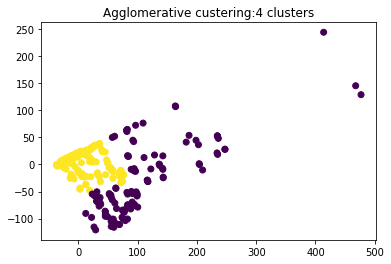

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.70

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  31.743690  0.660377  0.886792  187.032858   79.509434   
1  2.516255  28.797148  0.537061  0.364109   20.078922  143.005202   
2  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.641509  0.358491    0.547170     0.00000    0.452830  
1    0.332900  0.667100    0.146944     0.10013    0.752926  
2    0.347826  0.652174    0.376812     0.00000    0.623188  


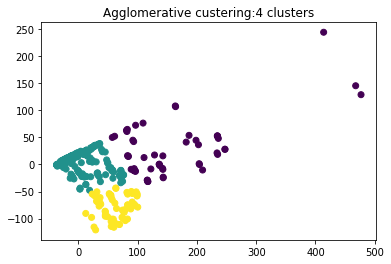

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.70

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.516255  28.797148  0.537061  0.364109   20.078922  143.005202   
1  1.000000  31.528312  0.700000  0.920000  167.515078   80.360000   
2  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.332900  0.667100    0.146944     0.10013    0.752926  
1    0.660000  0.340000    0.520000     0.00000    0.480000  
2    0.347826  0.652174    0.376812     0.00000    0.623188  
3    0.333333  0.666667    1.000000     0.00000    0.000000  


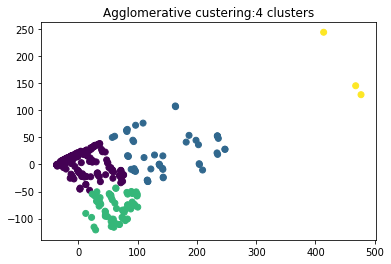

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.61

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  31.528312  0.700000  0.920000  167.515078   80.360000   
1  2.630592  27.987764  0.448773  0.356421   14.755945  145.396825   
2  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.473684  36.177457  1.342105  0.434211   68.616063  121.197368   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.660000  0.340000    0.520000    0.000000    0.480000  
1    0.317460  0.682540    0.129870    0.108225    0.761905  
2    0.347826  0.652174    0.376812    0.000000    0.623188  
3    0.333333  0.666667    1.000000    0.000000    0.000000  
4    0.473684  0.526316    0.302632    0.026316    0.671053  


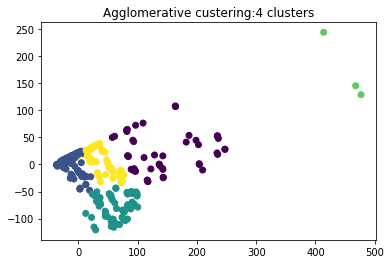

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.62

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.630592  27.987764  0.448773  0.356421   14.755945  145.396825   
1  1.473684  36.177457  1.342105  0.434211   68.616063  121.197368   
2  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.000000  32.391899  0.571429  0.742857  136.617731   92.342857   
5  1.000000  29.513275  1.000000  1.333333  239.608887   52.400000   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.317460  0.682540    0.129870    0.108225    0.761905  
1    0.473684  0.526316    0.302632    0.026316    0.671053  
2    0.347826  0.652174    0.376812    0.000000    0.623188  
3    0.333333  0.666667    1.000000    0.000000    0.000000  
4    0.657143  0.342857    0.542857    0.000000    0.457143  
5    0.666667  0.333333    0.466667    0.000

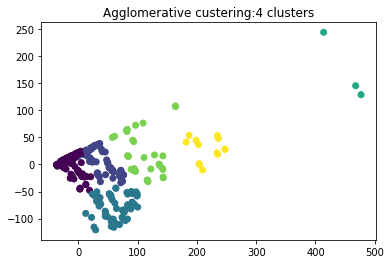

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.37

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.473684  36.177457  1.342105  0.434211   68.616063  121.197368   
1  1.000000  32.391899  0.571429  0.742857  136.617731   92.342857   
2  2.220657  38.886743  0.431925  0.511737   20.876507  142.061033   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  2.812500  23.151342  0.456250  0.287500   12.039946  146.877083   
5  1.000000  29.513275  1.000000  1.333333  239.608887   52.400000   
6  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.473684  0.526316    0.302632    0.026316    0.671053  
1    0.657143  0.342857    0.542857    0.000000    0.457143  
2    0.366197  0.633803    0.107981    0.056338    0.835681  
3    0.333333  0.666667    1.000000    0.000000    0.000000  
4    0.295833  0.704167    0.139583 

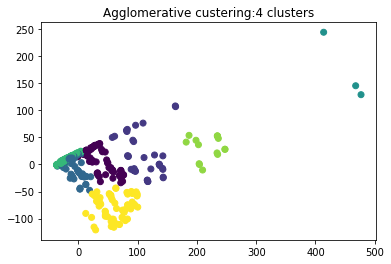

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.37

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  32.391899  0.571429  0.742857  136.617731   92.342857   
1  2.812500  23.151342  0.456250  0.287500   12.039946  146.877083   
2  2.220657  38.886743  0.431925  0.511737   20.876507  142.061033   
3  1.000000  35.333333  0.000000  0.333333  512.329200   65.333333   
4  1.800000  34.068634  1.755556  0.600000   64.244718  141.622222   
5  1.000000  29.513275  1.000000  1.333333  239.608887   52.400000   
6  1.000000  38.181032  0.260870  0.188406   48.413287   33.449275   
7  1.000000  39.238653  0.741935  0.193548   74.961565   91.548387   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.657143  0.342857    0.542857    0.000000    0.457143  
1    0.295833  0.704167    0.139583    0.131250    0.729167  
2    0.366197  0.633803    0.107981    0.056338    0.835681  
3    0.333333  0.666667    1

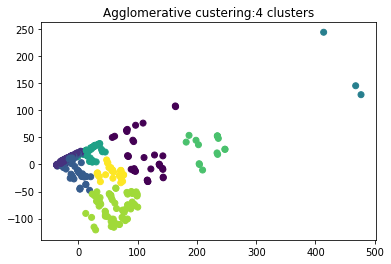

In [162]:
# Dimensionality reduction uses PCA. 
pca = PCA(n_components=2)
trainPca = pca.fit_transform(train)

# KMeans clustering
for clusterCount in range(2, 9):
    clusterLabels = clusterData(train, clusterCount=clusterCount, algorithm='KMeans')
    plt.scatter(trainPca[:, 0], trainPca[:, 1], c=clusterLabels)
    plt.title(f"KMeans clustering: {clusterCount} clusters")
    plt.show()

# Agglomerative clustering
for clusterCount in range(2, 9):
    clusterLabels = clusterData(train, clusterCount=clusterCount, algorithm='Agglomerative')
    plt.scatter(trainPca[:, 0], trainPca[:, 1], c=clusterLabels)
    plt.title(f"Agglomerative custering:{n_clusters} clusters")
    plt.show()

In [ ]:
#using 2 - 4 clusters gives highest silhouette score values and cluster profiling

C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.80

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.359897  29.481858  0.429306  0.359897   22.499213  142.316195   
1  1.000000  40.879310  0.689655  0.827586  211.723138  105.896552   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.347044  0.652956    0.213368    0.118252    0.668380  
1    0.586207  0.413793    0.655172    0.000000    0.344828  


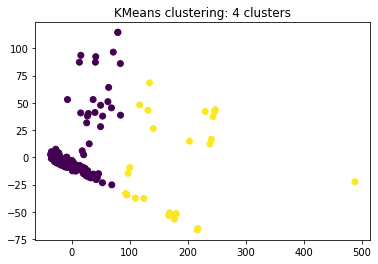

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.80

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.359897  29.481858  0.429306  0.359897   22.499213  142.316195   
1  1.000000  40.879310  0.689655  0.827586  211.723138  105.896552   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.347044  0.652956    0.213368    0.118252    0.668380  
1    0.586207  0.413793    0.655172    0.000000    0.344828  


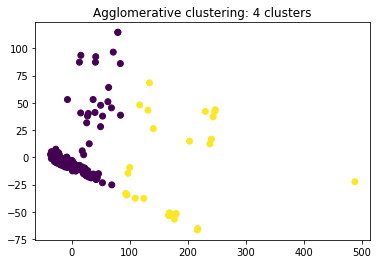

C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.70

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  41.428571  0.666667  0.428571   90.643652   97.142857   
1  2.477654  28.283360  0.405028  0.357542   18.260353  146.670391   
2  1.000000  43.805556  0.777778  1.000000  252.662506  102.444444   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.547619  0.452381    0.500000    0.023810    0.476190  
1    0.326816  0.673184    0.192737    0.125698    0.681564  
2    0.666667  0.333333    0.666667    0.000000    0.333333  


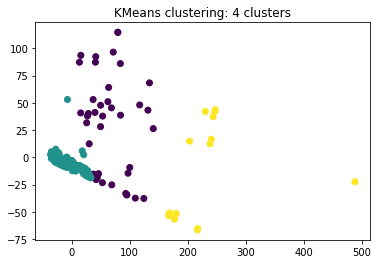

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.64

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.000000  40.879310  0.689655  0.827586  211.723138  105.896552   
1  1.285714  38.002420  0.875000  0.750000   66.155730  114.946429   
2  2.540541  28.048971  0.354354  0.294294   15.157576  146.918919   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.586207  0.413793    0.655172    0.000000    0.344828  
1    0.500000  0.500000    0.446429    0.017857    0.535714  
2    0.321321  0.678679    0.174174    0.135135    0.690691  


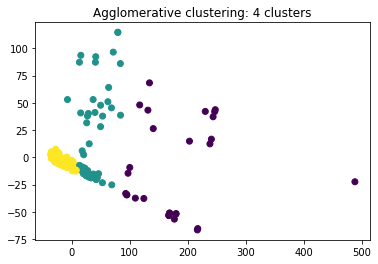

C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KMeans algorithm; cluster count: 4: 0.66

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.538922  28.055628  0.353293  0.293413   15.157242  146.748503   
1  1.000000  43.805556  0.777778  1.000000  252.662506  102.444444   
2  1.000000  45.200000  0.800000  0.440000   79.577996   66.080000   
3  1.365854  33.289340  0.853659  0.902439   80.299295  144.439024   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.320359  0.679641    0.176647    0.134731    0.688623  
1    0.666667  0.333333    0.666667    0.000000    0.333333  
2    0.640000  0.360000    0.400000    0.040000    0.560000  
3    0.414634  0.585366    0.512195    0.000000    0.487805  


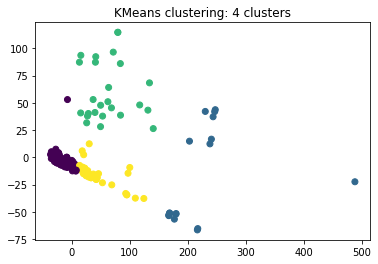

Silhouette Score for Agglomerative algorithm; cluster count: 4: 0.65

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  1.285714  38.002420  0.875000  0.750000   66.155730  114.946429   
1  1.000000  42.750000  1.250000  2.000000  287.562500   46.750000   
2  2.540541  28.048971  0.354354  0.294294   15.157576  146.918919   
3  1.000000  40.166667  0.476190  0.380952  182.831952  128.428571   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.500000  0.500000    0.446429    0.017857    0.535714  
1    0.625000  0.375000    0.750000    0.000000    0.250000  
2    0.321321  0.678679    0.174174    0.135135    0.690691  
3    0.571429  0.428571    0.619048    0.000000    0.380952  


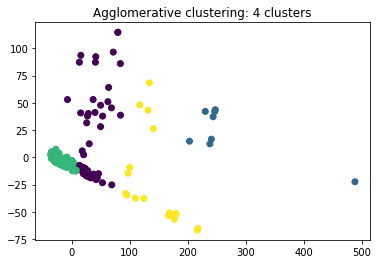

In [161]:
#Test data 
pca = PCA(n_components=2)
testPca = pca.fit_transform(test)

for clusterCount in range(2, 5):
    # KMeans clustering
    clusterLabels = clusterData(test, clusterCount=clusterCount, algorithm='KMeans')
    plt.scatter(testPca[:, 0], testPca[:, 1], c=clusterLabels)
    plt.title(f"KMeans clustering: {n_clusters} clusters")
    plt.show()
    
    # Agglomerative Clustering
    clusterLabels = clusterData(test, clusterCount=clusterCount, algorithm='Agglomerative')
    plt.scatter(testPca[:, 0], testPca[:, 1], c=clusterLabels)
    plt.title(f"Agglomerative clustering: {n_clusters} clusters")
    plt.show()

In [132]:
print("In conclusion We can observe from the data that the KMeans and Agglomerative clustering algorithms both\n" + 
      "produced the maximum silhouette score of 0.80 when employing 2 clusters.\n" 
      "This shows that the clusters' objects are very similar to one another and very different from those in \n" 
      "other clusters. The study of the cluster profiles reveals that the two clusters are considerably distinct,\n"  
      "with one having greater values for Pclass, Age, SibSp, and Parch and the other having higher values for \n" 
      "Fare and the number of cabins. Between the two clusters, there are also differences in the Sex and \n" 
      "Embarked values.")

In conclusion We can observe from the data that the KMeans and Agglomerative clustering algorithms both
produced the maximum silhouette score of 0.80 when employing 2 clusters.
This shows that the clusters' objects are very similar to one another and very different from those in 
other clusters. The study of the cluster profiles reveals that the two clusters are considerably distinct,
with one having greater values for Pclass, Age, SibSp, and Parch and the other having higher values for 
Fare and the number of cabins. Between the two clusters, there are also differences in the Sex and 
Embarked values.


In [163]:
clusterLabelsKmeans = clusterData(test, 2, algorithm='KMeans')
clusterLabelsKmeans

Silhouette Score for KMeans algorithm; cluster count: 4: 0.80

Profiling clusters...
      Pclass        Age     SibSp     Parch        Fare       Cabin  \
0  2.359897  29.481858  0.429306  0.359897   22.499213  142.316195   
1  1.000000  40.879310  0.689655  0.827586  211.723138  105.896552   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0    0.347044  0.652956    0.213368    0.118252    0.668380  
1    0.586207  0.413793    0.655172    0.000000    0.344828  


C:\Users\Mirgo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [164]:
survivedPassanger = {}
j = 0;
with open(testData, 'r') as f:
    reader = csv.reader(f)
    for i in cluster_labels_kmeans:
        userCount = row[0]
        survivedPassanger[j] = i;
        j+=1

# Write out the user ID and score data to a new CSV file
with open('result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["PassengerId", "Survived"])
    for userCount, score in survivedPassanger.items():
        writer.writerow([892 + userCount, score])